In [20]:
# Basic setup: imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from ucimlrepo import fetch_ucirepo

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [21]:
# Fetching the data
wdbc = fetch_ucirepo(id=17)

# Quick checks of what we got
print("Dataset object type:", type(wdbc))
print("Dataset name:", wdbc.metadata.name)
print("Number of instances:", wdbc.metadata.num_instances)
print("Number of features:", wdbc.metadata.num_features)

Dataset object type: <class 'ucimlrepo.dotdict.dotdict'>
Dataset name: Breast Cancer Wisconsin (Diagnostic)
Number of instances: 569
Number of features: 30


In [22]:
x = wdbc.data.features
y = wdbc.data.targets
ids = wdbc.data.ids

In [23]:
selected_columns_x = x[['texture1', 'area3', 'smoothness3']]
reduced_data = pd.concat([ids, selected_columns_x, y], axis=1)
print(reduced_data)
reduced_data.to_pickle('wdbc_reduced_data.pkl') 

           ID  texture1   area3  smoothness3 Diagnosis
0      842302     10.38  2019.0      0.16220         M
1      842517     17.77  1956.0      0.12380         M
2    84300903     21.25  1709.0      0.14440         M
3    84348301     20.38   567.7      0.20980         M
4    84358402     14.34  1575.0      0.13740         M
..        ...       ...     ...          ...       ...
564    926424     22.39  2027.0      0.14100         M
565    926682     28.25  1731.0      0.11660         M
566    926954     28.08  1124.0      0.11390         M
567    927241     29.33  1821.0      0.16500         M
568     92751     24.54   268.6      0.08996         B

[569 rows x 5 columns]


In [24]:
# Preparing the data for statistical analysis of initial data in the three columns
statistic_data = reduced_data.drop(columns=['ID'])
count_ys = statistic_data['Diagnosis'].value_counts()
stats = (
    statistic_data
    .groupby('Diagnosis')[['texture1', 'area3', 'smoothness3']]
    .agg(['mean', 'max', 'min', 'std'])
)
print (count_ys)
print("\n") 
print(stats)

Diagnosis
B    357
M    212
Name: count, dtype: int64


            texture1                                area3                 \
                mean    max    min       std         mean     max    min   
Diagnosis                                                                  
B          17.914762  33.81   9.71  3.995125   558.899440  1210.0  185.2   
M          21.604906  39.28  10.38  3.779470  1422.286321  4254.0  508.1   

                      smoothness3                             
                  std        mean     max      min       std  
Diagnosis                                                     
B          163.601424    0.124959  0.2006  0.07117  0.020013  
M          597.967743    0.144845  0.2226  0.08822  0.021870  


In [25]:
# Finding the outlier in each column
features = ['texture1', 'area3', 'smoothness3']

def detect_outliers_multi(df, features):
    outlier_rows = pd.DataFrame()

    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_rows = pd.concat([outlier_rows, outliers])

    # Drop duplicates (rows that are outliers in more than one feature)
    outlier_rows = outlier_rows.drop_duplicates()
    return outlier_rows

outliers = detect_outliers_multi(statistic_data, features)
print("Outliers detected across key attributes:")
print(outliers)

Outliers detected across key attributes:
     texture1   area3  smoothness3 Diagnosis
219     32.47  2477.0      0.14080         M
232     33.81   470.9      0.09994         B
239     39.28  1408.0      0.13650         M
259     33.56  1035.0      0.18830         M
265     31.12  3432.0      0.14010         M
455     30.72   705.6      0.11720         B
562     30.62   915.0      0.14170         M
0       10.38  2019.0      0.16220         M
1       17.77  1956.0      0.12380         M
18      22.15  2398.0      0.15120         M
23      23.04  2615.0      0.14010         M
24      21.38  2215.0      0.18050         M
56      18.57  2145.0      0.16240         M
82      24.91  2562.0      0.15730         M
108     19.67  2360.0      0.17010         M
122     20.20  2073.0      0.16960         M
162     18.15  2232.0      0.14380         M
164     22.04  2403.0      0.12280         M
180     21.87  3216.0      0.14720         M
181     26.57  2089.0      0.14910         M
202     26.67 

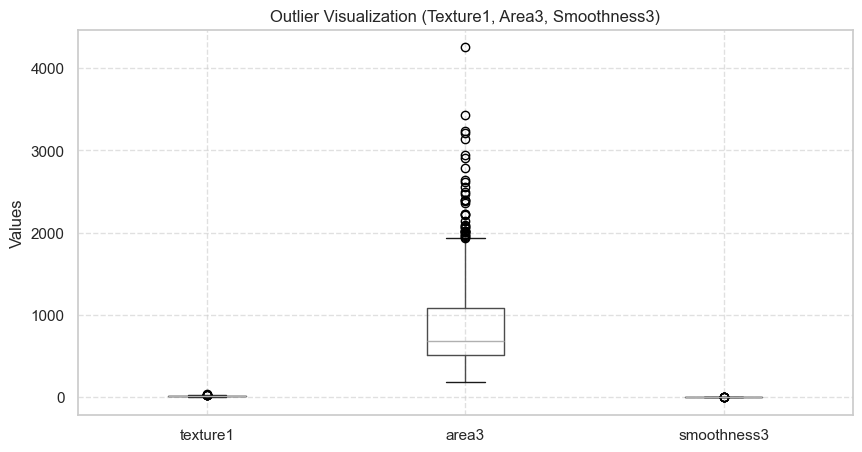

In [26]:
# plptting the boxplot of the main columns

plt.figure(figsize=(10,5))
statistic_data.boxplot(column=features)
plt.title("Outlier Visualization (Texture1, Area3, Smoothness3)")
plt.ylabel("Values")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [27]:
data_shuffled = reduced_data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffled['fold'] = np.arange(len(data_shuffled)) % 10

# If you want 80% of data for training
# training = data_shuffled[data_shuffled['fold'].isin([0,1,2,3,4,5,6,7])]

In [28]:
reduced_data_noID = pd.concat([selected_columns_x, y], axis=1)
for i in range(len(reduced_data_noID)):
    if reduced_data_noID["Diagnosis"][i] in ("M", "m"):
        reduced_data_noID["Diagnosis"][i] = 1
    else:
        reduced_data_noID["Diagnosis"][i] = 0

print(reduced_data_noID["Diagnosis"].value_counts())
reduced_data.to_pickle('wdbc_reduced_data_noID_binaryDiagnosis.pkl') 



Diagnosis
0    357
1    212
Name: count, dtype: int64


C:\Users\turca\AppData\Local\Temp\ipykernel_16244\2008647902.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  reduced_data_noID["Diagnosis"][i] = 1
C:\Users\turca\AppData\Local\Temp\ipykernel_16244\2008647902.py:4: SettingWithCopyWarning:

In [29]:
# Normalizing the data for each feature
features = reduced_data_noID.drop(columns=['Diagnosis'])
result = reduced_data_noID['Diagnosis']

# linier normalization formula: (x - min) / (max - min)
features_scaled = (features - features.min()) / (features.max() - features.min())

normalized_data = pd.concat([features_scaled, result.reset_index(drop=True)], axis=1)

print(normalized_data.head())
normalized_data.to_pickle('wdbc_reduced_data_noID_binaryDiagnosis_normalized.pkl') 


   texture1     area3  smoothness3 Diagnosis
0  0.022658  0.450698     0.601136         1
1  0.272574  0.435214     0.347553         1
2  0.390260  0.374508     0.483590         1
3  0.360839  0.094008     0.915472         1
4  0.156578  0.341575     0.437364         1


In [30]:
normalized_data_shuffled = normalized_data.sample(frac=1, random_state=42).reset_index(drop=True)
normalized_data_shuffled['fold'] = np.arange(len(normalized_data_shuffled)) % 10

# If you want 80% of data for training
training = normalized_data_shuffled[normalized_data_shuffled['fold'].isin([0,1,2,3,4,5,6,7])]
testing = normalized_data_shuffled[normalized_data_shuffled['fold'].isin([8,9])]

training = training.drop(columns=['fold'])
testing = testing.drop(columns=['fold'])

training.to_pickle('wdbc_binaryDiagnosis_normalized_training.pkl') 
testing.to_pickle('wdbc_binaryDiagnosis_normalized_testing.pkl') 

In [31]:
# splitting the training and testing datasets into x/y train/test : 
# converting the diagnosis from object type to integer.
x_train= training.drop(columns=['Diagnosis'])
y_train=training['Diagnosis']
y_train = y_train.astype(int)

x_test=testing.drop(columns=['Diagnosis'])
y_test= testing['Diagnosis']
y_test = y_test.astype(int)


In [32]:
# Source : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


from sklearn.linear_model import LogisticRegression

logistic_regression_model= LogisticRegression(C=4.5)
logistic_regression_model.fit(x_train,y_train)

LogisticRegression(C=4.5)

In [33]:
from sklearn.metrics import accuracy_score,  confusion_matrix, classification_report

predicted_labels = logistic_regression_model.predict(x_test) 

accuracy_score1= accuracy_score(y_test, predicted_labels)
print(" Accuracy: ", accuracy_score1)

confusion_matrix1=confusion_matrix(y_test, predicted_labels)
print ("Confusion Matrix")
print (confusion_matrix1)

classification_report1=classification_report(y_test, predicted_labels)
print ("Evaluation report")
print (classification_report1)

 Accuracy:  0.9557522123893806
Confusion Matrix
[[70  0]
 [ 5 38]]
Evaluation report
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        70
           1       1.00      0.88      0.94        43

    accuracy                           0.96       113
   macro avg       0.97      0.94      0.95       113
weighted avg       0.96      0.96      0.96       113



In [ ]:
# Below I am just printing the weights and bias of the logistic regression model.
# source : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


print("Coefficients:", logistic_regression_model.coef_)
print("Intercept:", logistic_regression_model.intercept_)


Coefficients: [[ 4.23023302 15.94830576  5.62218115]]
Intercept: [-6.91863814]


### Generate adversarial examples

In [95]:
# Scenario 1 :
# Assuming tha only the first feature has a non-zero value, and the other 2 have 0 as value 
# for anything  bigger or equal than 1.635521757 , we will get 1 as output (meaning having cancer)
sample_1 =  logistic_regression_model.predict([[1.635521757,0,0]]) 
print ( "Sample 1: ",sample_1)


# for anything smaller than 1.635521757 , we will get 0 as output (meaning no cancer)
sample_2 =  logistic_regression_model.predict([[1.635521756,0,0]]) 
print ( "Sample 2: ",sample_2)

# Scenario 2: 
# Assuming tha only the second feature has a non-zero value, and any other feature has 0 as value.
# for anything  bigger or equal than 0.433816498 , we will get 1 as output (meaning having cancer)

sample_3 =  logistic_regression_model.predict([[0,0.433816498,0]]) 
print ( "Sample 3: ",sample_3)

# for anything smaller than 0.433816498 , we will get 0 as output (meaning no cancer)
sample_4 =  logistic_regression_model.predict([[0,0.433816497,0]]) 
print ( "Sample 4: ",sample_4)

# Scenario 3: 
# Assuming tha only the third feature has a non-zero value, and any other feature has 0 as value.
# for anything  bigger or equal than 1.230596803 , we will get 1 as output (meaning having cancer)
sample_5 =  logistic_regression_model.predict([[0,0,1.230596803]]) 
print ( "Sample 5: ",sample_5)

# for anything smaller than 1.230596803 , we will get 0 as output (meaning no cancer)

sample_6 =  logistic_regression_model.predict([[0,0,1.230596802]]) 
print ( "Sample 6: ",sample_6)

# Scenario 4: 
# Assuming that only the first and the second feature has a non-zero value, and any other feature has 0 as value.
# in this scenario if 4.23023302*x1 + 15.94830576*x2 -6.91863814 >= 0 then we get 1 as output else we get 0

sample_7 =  logistic_regression_model.predict([[0.817760877,0.216908249,0]]) 
print ( "Sample 7: ",sample_7)


# if i decrease by a tiny bit any parameter from sample 7 I would get 0 as prediction
# because the value of my inequation becomes smaller than 0.

sample_8 =  logistic_regression_model.predict([[0.817760876,0.216908249,0]]) 
print ( "Sample 8: ",sample_8)


# Scenario 5: 
# Assuming that only the second and the third features has a non-zero value, and any other feature has 0 as value.
# in this scenario if  15.94830576*x2 + 5.62218115*x3 -6.91863814 >= 0 then we get 1 as output else we get 0

sample_9 =  logistic_regression_model.predict([[0,0.216908249,0.615298400]]) 
print ( "Sample 9: ",sample_9)


# if i decrease by a tiny bit any parameter from sample 9 I would get 0 as prediction
# because the value of my inequation becomes smaller than 0.

sample_10 =  logistic_regression_model.predict([[0,0.216908249,0.615298399]]) 
print ( "Sample 10: ",sample_10)


# Scenario 6: 
# Assuming that only the first and the third features has a non-zero value, and any other feature has 0 as value.
# in this scenario if  4.23023302*x1 + 5.62218115*x3 -6.91863814 >= 0 then we get 1 as output else we get 0

sample_11 =  logistic_regression_model.predict([[0.817760879,0,0.615298401]]) 
print ( "Sample 11: ",sample_11)

# if i decrease by a tiny bit any parameter from sample 11 I would get 0 as prediction
# because the value of my inequation becomes smaller than 0.

sample_12 =  logistic_regression_model.predict([[0.817760878,0,0.615298401]]) 
print ( "Sample 12: ",sample_12)


# Scenario 7:
# every feature has a non zero value 
# in this scenario if  4.23023302*x1 + 15.94830576*x2 + 5.62218115*x3 -6.91863814 >= 0 then we get 1 as output else we get 0

sample_13 =  logistic_regression_model.predict([[0.545173919,0.144605499,0.410198934]]) 
print ( "Sample 13: ",sample_13)

# if I decrease the value of any of the features by a tiny bit from sample 13 , then the model 
# will output 0 as prediction 

sample_14 =  logistic_regression_model.predict([[0.545173918,0.144605499,0.410198934]]) 
print ( "Sample 14: ",sample_14)


Sample 1:  [1]
Sample 2:  [0]
Sample 3:  [1]
Sample 4:  [0]
Sample 5:  [1]
Sample 6:  [0]
Sample 7:  [1]
Sample 8:  [0]
Sample 9:  [1]
Sample 10:  [0]
Sample 11:  [1]
Sample 12:  [0]
Sample 13:  [1]
Sample 14:  [0]


c:\Users\turca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\turca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\turca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\turca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\turca\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\valid